In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
from scipy.interpolate import Rbf  
import utm
import pymysql
import datetime
from datetime import date, timedelta

#Get data

###Get trap location data from MySQL table 'YigoBarrelLocations'

In [4]:
conn = pymysql.connect(host='mysql.guaminsects.net',user='readonlyguest',passwd='readonlypassword',db='oryctes')
sql = 'SELECT * FROM YigoBarrelLocations;'
df_loc = pd.io.sql.read_sql(sql, conn)
conn.close()

###Convert latitude and longitude to UTM (cartesian coordinates in meters)

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

df_loc['northing'] = 0.0; df_loc['easting'] = 0.0; df_loc['zone'] = ''
for index, row in df_loc.iterrows():
    u = utm.from_latlon(row.latitude, row.longitude)
    df_loc.easting[index] = u[0]
    df_loc.northing[index] = u[1]
    df_loc.zone[index] = u[2]
df_loc.tail()

,barrelID,latitude,longitude,northing,easting,zone
26,10,13.532147,144.871810,1496986.364658,269670.281306,55
27,18,13.530595,144.870708,1496815.647246,269549.439269,55
28,16,13.531306,144.873112,1496892.061610,269810.440125,55
29,23,13.530034,144.870936,1496753.292563,269573.621934,55
30,24,13.529760,144.872243,1496721.825673,269714.861865,55


###Get barrel trap catch data from MySQL table 'YigoBarrelObs'

In [6]:
conn = pymysql.connect(host='mysql.guaminsects.net',user='readonlyguest',passwd='readonlypassword',db='oryctes')
sql = 'SELECT * FROM YigoBarrelObs;'
df_obs = pd.io.sql.read_sql(sql, conn)
conn.close()
df_obs.tail()

,id,barrelID,trapType,lure,uvled,funnel,substrate,startDate,endDate,males,females,notes
1878,3470,23,P,y,y,y,n,2015-06-26,2015-06-29,0,0,0
1879,3471,26,P,y,y,y,y,2015-06-26,2015-06-29,0,2,0
1880,3472,29,P,y,y,y,n,2015-06-26,2015-06-29,0,3,0
1881,3473,30,P,y,y,y,y,2015-06-26,2015-06-29,1,2,0
1882,3474,31,P,y,y,y,n,2015-06-26,2015-06-29,0,0,0


In [7]:
df_obs['days'] =(df_obs['endDate'] - df_obs['startDate']) / np.timedelta64(1, 'D')
df_obs['trapCatch'] = df_obs['males'] + df_obs['females']
df_obs['trapRate'] = df_obs['trapCatch'] / df_obs['days']
df_obs.tail()

,id,barrelID,trapType,lure,uvled,funnel,substrate,startDate,endDate,males,females,notes,days,trapCatch,trapRate
1878,3470,23,P,y,y,y,n,2015-06-26,2015-06-29,0,0,0,3,0,0.000000
1879,3471,26,P,y,y,y,y,2015-06-26,2015-06-29,0,2,0,3,2,0.666667
1880,3472,29,P,y,y,y,n,2015-06-26,2015-06-29,0,3,0,3,3,1.000000
1881,3473,30,P,y,y,y,y,2015-06-26,2015-06-29,1,2,0,3,3,1.000000
1882,3474,31,P,y,y,y,n,2015-06-26,2015-06-29,0,0,0,3,0,0.000000


In [8]:
df_obs.drop(['id','trapType', 'lure','uvled','funnel','substrate','males','females','notes','trapCatch','endDate'],1,inplace=True)
#df_obs.rename(columns={'barrelID':'trapID'}, inplace=True)
df_obs.tail()

,barrelID,startDate,days,trapRate
1878,23,2015-06-26,3,0.000000
1879,26,2015-06-26,3,0.666667
1880,29,2015-06-26,3,1.000000
1881,30,2015-06-26,3,1.000000
1882,31,2015-06-26,3,0.000000


In [9]:
df_merge = pd.DataFrame.merge(df_obs,df_loc,on='barrelID')
df_merge.drop(['latitude','longitude','zone'], 1, inplace=True)
df_merge.tail()

,barrelID,startDate,days,trapRate,northing,easting
1878,31,2015-05-08,20,0.15,1496621.703646,269937.279229
1879,31,2015-05-28,8,0.25,1496621.703646,269937.279229
1880,31,2015-06-05,6,0.50,1496621.703646,269937.279229
1881,31,2015-06-11,6,0.00,1496621.703646,269937.279229
1882,31,2015-06-26,3,0.00,1496621.703646,269937.279229


In [10]:
rows_list = []
for index, row in df_merge.iterrows():
    for n in range(int(row.days)):
        dict1 = {}
        dict1['date'] = row.startDate + n*datetime.timedelta(1)
        dict1['barrelID'] = row.barrelID
        dict1['northing'] = row.northing
        dict1['easting'] = row.easting
        dict1['trapRate'] = row.trapRate
        rows_list.append(dict1)
df_daily = pd.DataFrame(rows_list)
#df_daily.set_index('date')
df_daily

,barrelID,date,easting,northing,trapRate
0,1,2014-05-12,269557.061619,1497139.555131,0.428571
1,1,2014-05-13,269557.061619,1497139.555131,0.428571
2,1,2014-05-14,269557.061619,1497139.555131,0.428571
3,1,2014-05-15,269557.061619,1497139.555131,0.428571
4,1,2014-05-16,269557.061619,1497139.555131,0.428571
5,1,2014-05-17,269557.061619,1497139.555131,0.428571
6,1,2014-05-18,269557.061619,1497139.555131,0.428571
7,1,2014-05-19,269557.061619,1497139.555131,0.000000
8,1,2014-05-20,269557.061619,1497139.555131,0.000000
9,1,2014-05-21,269557.061619,1497139.555131,0.000000


###To start, let's do a plot of total beetles

In [11]:
def slicer(endDate, daysPrior, df_daily = df_daily):
    '''
    Returns a data frame containing all records from df_daily
    where dates range from (endDate - daysPrior) to (endDate - 1)
    '''
#    d2 = datetime.datetime.strptime(endDate, '%Y-%m-%d')
    d2 = endDate
    d1 = d2 - datetime.timedelta(days=daysPrior)
    grouped = df_daily[(df_daily['date'] >= d1) & (df_daily['date'] < d2)].groupby('barrelID')
    df = grouped.aggregate(np.mean)
    return df

In [12]:
# Polygon must be counter-clockwise
df_poly = pd.DataFrame()
df_poly['longitude'] = [144.8706001226,144.8742714358,144.874198734,144.8740684691,144.874190255,
             144.8748338098,144.8725272602,144.8720885558,144.8708851476,144.8706001226]
df_poly['latitude'] = [13.5288887697,13.5288882948,13.5298348952,13.5298349121,13.5306824527,
            13.5334919087,13.5325601914,13.5335571252,13.5335410279,13.5288887697]
df_poly['northing'] = 0.0; df_poly['easting'] = 0.0; df_poly['zone'] = ''
for index, row in df_poly.iterrows():
    u = utm.from_latlon(row.latitude, row.longitude)
    df_poly.easting[index] = u[0]
    df_poly.northing[index] = u[1]
    df_poly.zone[index] = u[2]
    
    # df_poly = read_polygon()

# Manual adjustment of polygon
    
#df_poly['easting'][0] = df_poly['easting'][0] - 10
df_poly['northing'][0] = df_poly['northing'][0] - 10
    
df_poly['easting'][1] = df_poly['easting'][1] + 10
df_poly['northing'][1] = df_poly['northing'][1] - 10
    
df_poly['easting'][2] = df_poly['easting'][2] + 10
#df_poly['northing'][2] = df_poly['northing'][2] + 10

df_poly['easting'][3] = df_poly['easting'][3] + 10
#df_poly['northing'][3] = df_poly['northing'][3] + 10

df_poly['easting'][4] = df_poly['easting'][4] + 10
#df_poly['northing'][4] = df_poly['northing'][4] - 10
    
df_poly['easting'][5] = df_poly['easting'][5] + 10
df_poly['northing'][5] = df_poly['northing'][5] + 10
     
#df_poly['easting'][6] = df_poly['easting'][6] + 10
df_poly['northing'][6] = df_poly['northing'][6] + 10
    
#df_poly['easting'][7] = df_poly['easting'][7] + 10
df_poly['northing'][7] = df_poly['northing'][7] + 10

df_poly['easting'][8] = df_poly['easting'][8] - 20
df_poly['northing'][8] = df_poly['northing'][8] + 10
    
#df_poly['easting'][9] = df_poly['easting'][9] - 20
df_poly['northing'][9] = df_poly['northing'][9] - 10
    
#plt.plot(df_poly.easting, df_poly.northing, linewidth=1, color='black')
myp = [
        (df_poly.easting[0], df_poly.northing[0]),
        (df_poly.easting[1], df_poly.northing[1]),
        (df_poly.easting[2], df_poly.northing[2]),
        (df_poly.easting[3], df_poly.northing[3]),
        (df_poly.easting[4], df_poly.northing[4]),
        (df_poly.easting[5], df_poly.northing[5]),
        (df_poly.easting[6], df_poly.northing[6]),
        (df_poly.easting[7], df_poly.northing[7]),
        (df_poly.easting[8], df_poly.northing[8]),
        (df_poly.easting[9], df_poly.northing[9])
        ]
    
df_poly

,longitude,latitude,northing,easting,zone
0,144.870600,13.528889,1496616.933733,269536.162022,55
1,144.874271,13.528888,1496613.426519,269943.669533,55
2,144.874199,13.529835,1496728.244816,269936.707459,55
3,144.874068,13.529835,1496728.369174,269922.603236,55
4,144.874190,13.530682,1496822.042740,269936.603925,55
5,144.874834,13.533492,1497142.329481,270008.983082,55
6,144.872527,13.532560,1497041.396208,269748.352317,55
7,144.872089,13.533557,1497152.129107,269701.811954,55
8,144.870885,13.533541,1497151.481050,269551.501045,55
9,144.870600,13.528889,1496616.933733,269536.162022,55


In [13]:
def read_polygon():
# df_poly = pd.DataFrame.from_csv('Yigo UOG Ag Expt Stn polygon counter.csv', index_col=False )
    return df_poly

In [14]:
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch


In [15]:
def plotmap(df):
    #df = slicer('2015-05-01', 90)
    #NOTE: Need to try colormesh. Faster than colrbar??
    x = df.easting.values
    y = df.northing.values
    values = df.trapRate.values
    vmin = 0; vmax = 0.5

    #Creating the output grid (100x100, in the example)  
    tx = np.linspace(min(x)-50, max(x)+50, 100)  
    ty = np.linspace(min(y)-50, max(y)+50, 100)
    XI, YI = np.meshgrid(tx, ty)  

    #Creating the interpolation function and populating the output matrix value  
    rbf = Rbf(x, y, values, function='multiquadric')  
    ZI = rbf(XI, YI)  

    # Plotting the result  
    #n = plt.Normalize(0.0, 100.0)  
    #plt.subplot(1, 1, 1) 
    plt.figure(figsize=(10,10))
    plt.axes().set_aspect(1.0) 
    plt.pcolor(XI, YI, ZI, vmin=vmin, vmax=vmax) 
    plt.colorbar()
    myplot = plt.scatter(x, y, 100, values, vmin=vmin, vmax=vmax) 
    #plt.title('RBF interpolation')  
    plt.xlim(min(tx), max(tx))  
    plt.ylim(min(ty), max(ty)) 
    plt.plot(df_poly.easting, df_poly.northing, linewidth=1, color='black')
    #plt.colorbar()
    for index, row in df.iterrows():
        plt.annotate(
            index, 
            xy = (row.easting, row.northing), xytext = (0, 12),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.30))
    mask_outside_polygon(myp)
    return myplot  

In [16]:
def date_list(d1, d2):
    'returns list containing first date in month from d1 to d2'
    dlist = []
    d1 = date(2014, 6, 1)
    d2 = date.today()
    for year in range(d1.year, d2.year+1):
        for month in range(1,13):
            d = date(year, month, 1)
            if (d >= d1) & (d <= d2):
                dlist.append(date(year, month, 1))
    return dlist

In [17]:
def plot_bars():
    #dateTicks = []
    #for d in plot_dates:
    #    dateTicks.append(date.strftime(d, '%b%y'))
    #dateTicks

    colors = []
    for i in trapRateMeans:
        colors.append('blue')

    for i in range(len(trapRateMeans)):
        colors[i] = 'red'
        fig = plt.figure()
        plt.bar(left=np.arange(len(plot_dates)), height=trapRateMeans, color=colors)
        #plt.xticks(0.5 + np.arange(len(dateTicks)), dateTicks)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off') # labels along the bottom edge are off
        filename = 'bars%s.png' % (plot_dates[i].strftime('%Y-%m-%d'))
        fig.savefig(filename)
        colors[i] = 'blue'

/home/aubreymoore/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


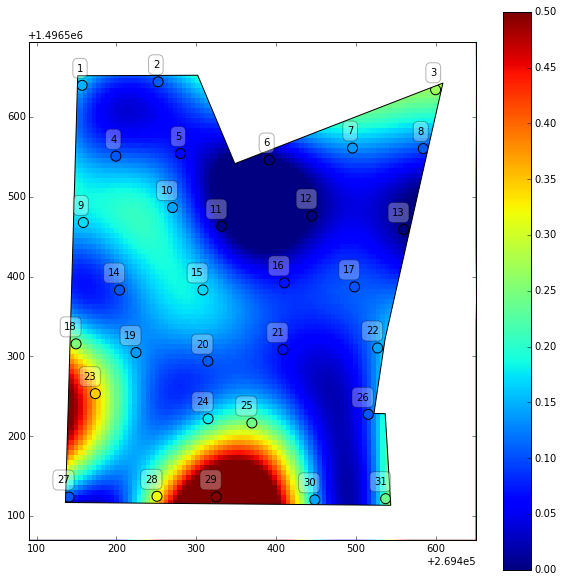

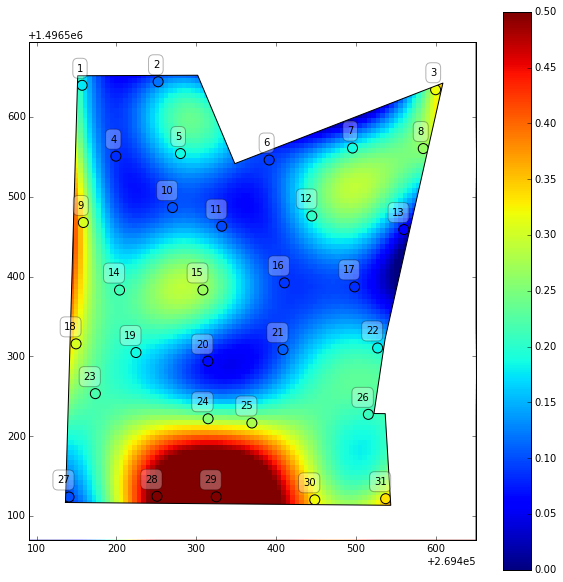

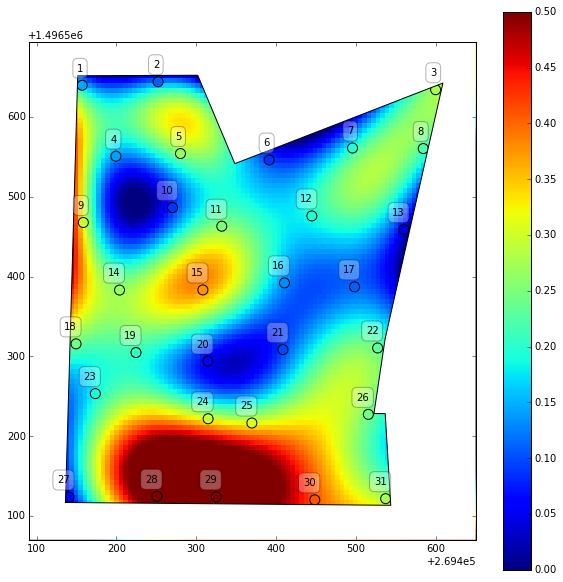

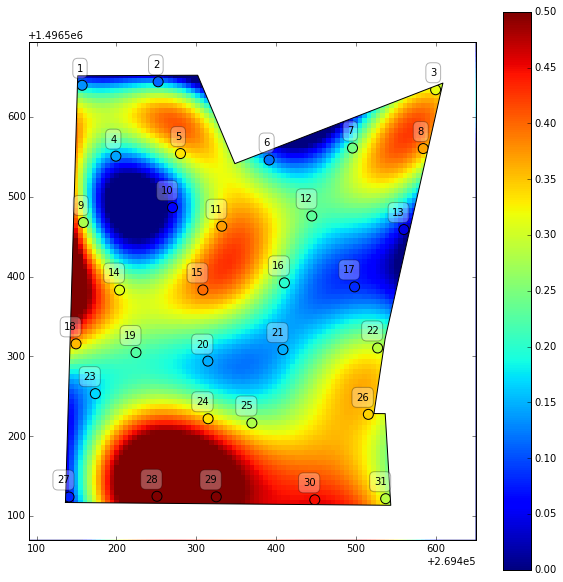

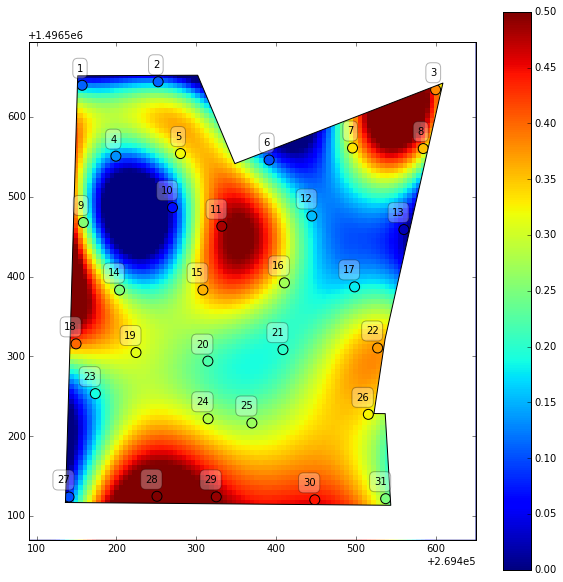

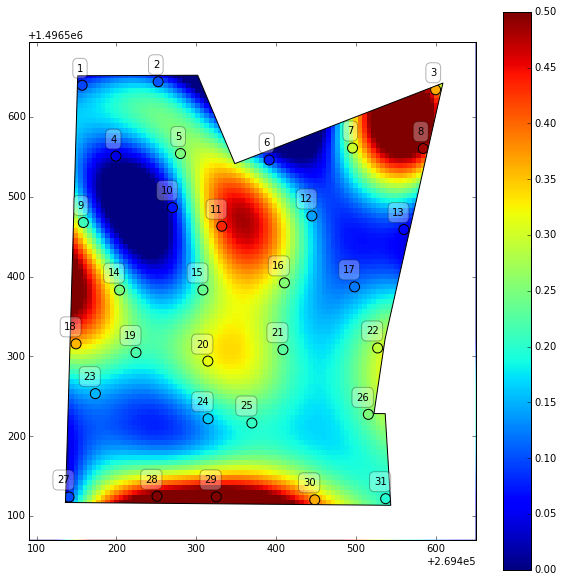

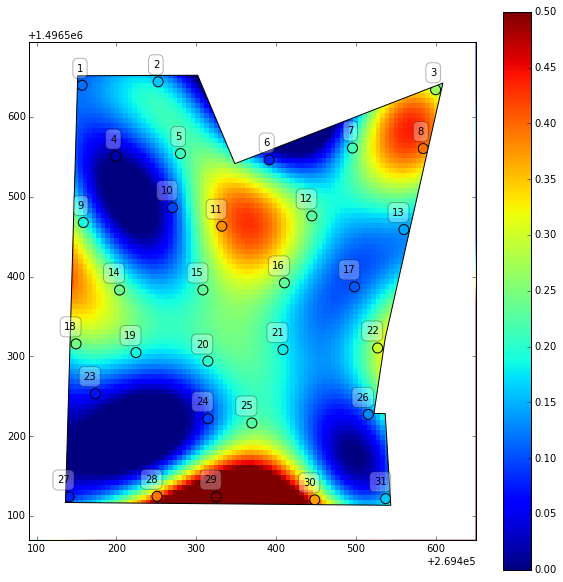

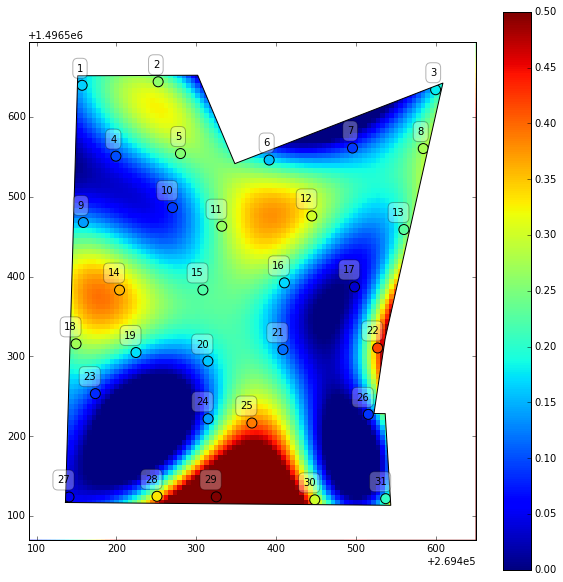

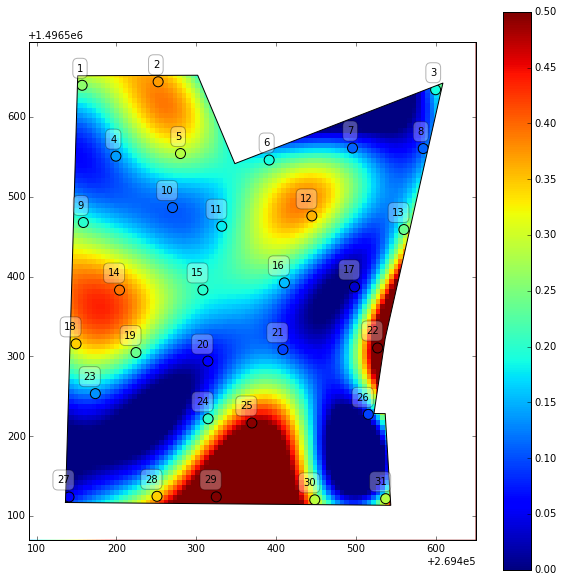

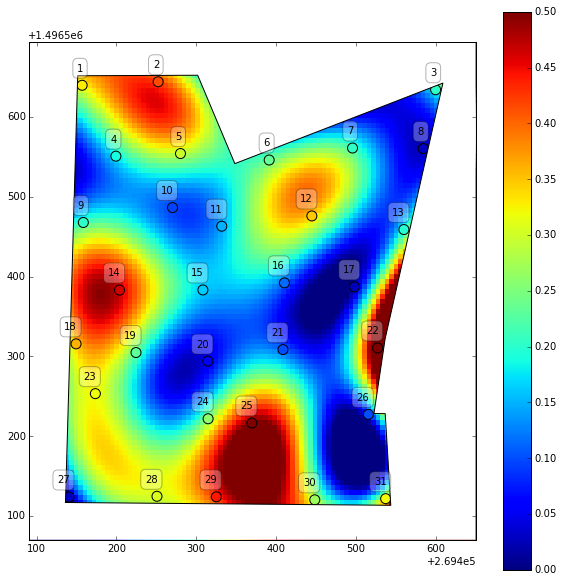

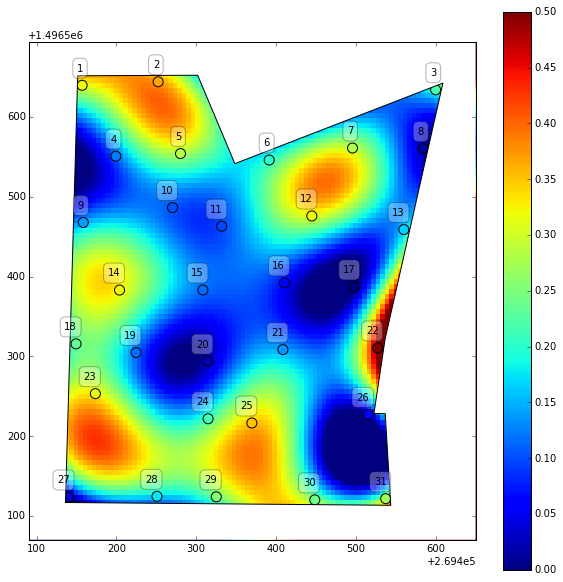

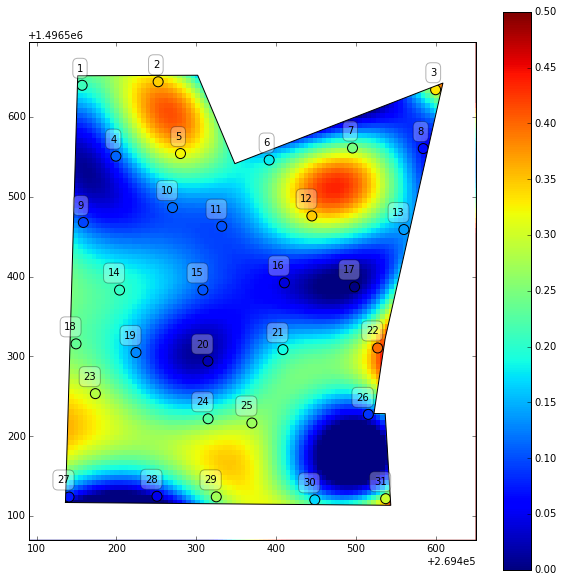

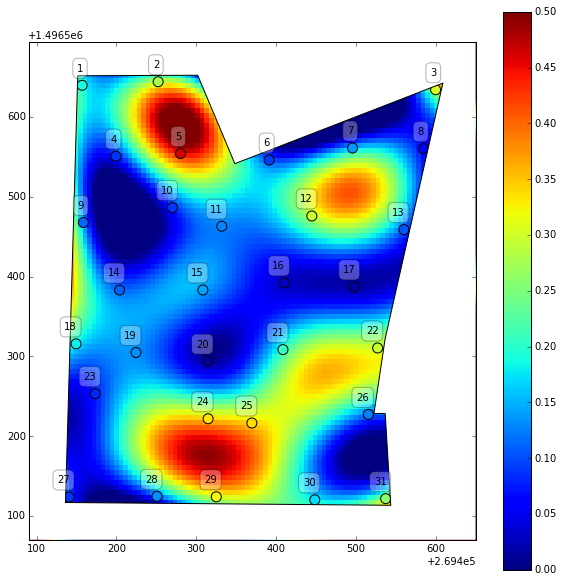

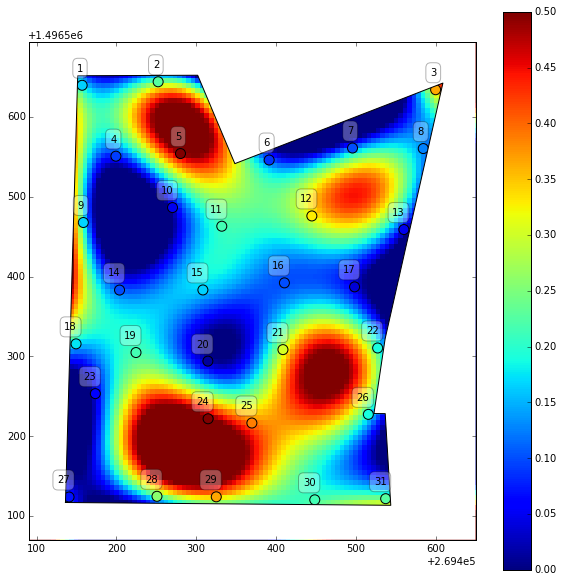

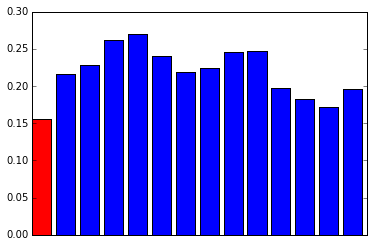

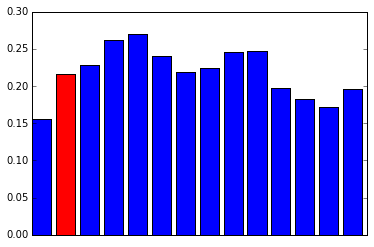

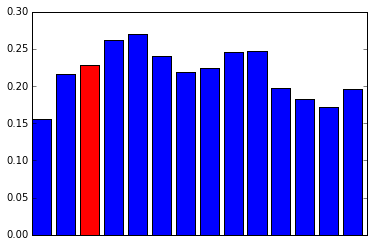

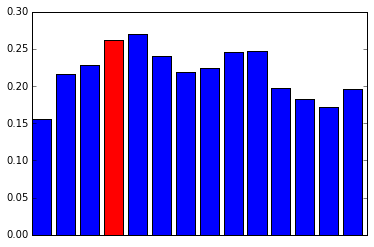

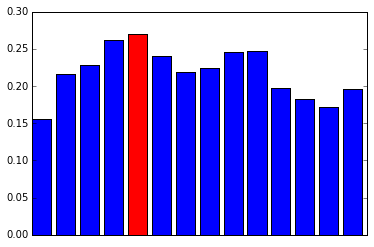

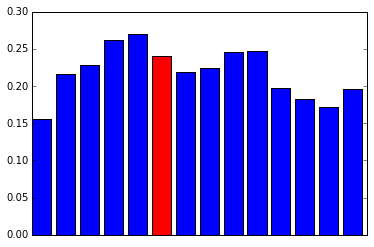

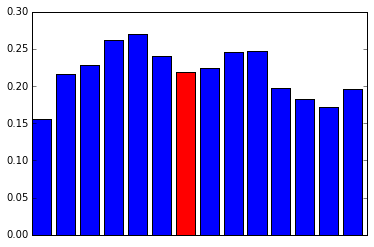

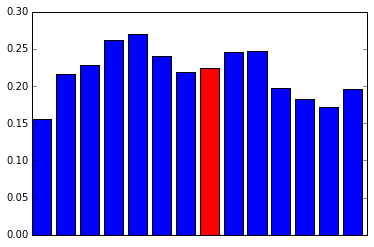

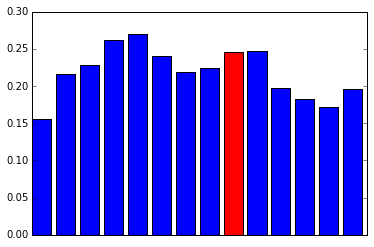

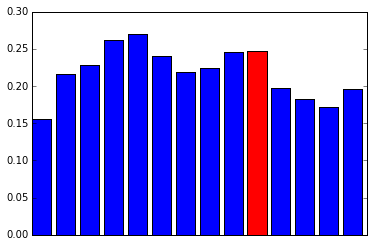

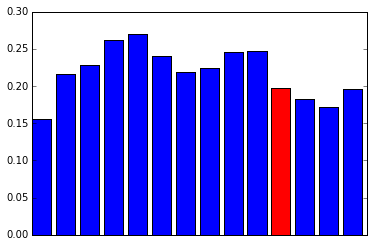

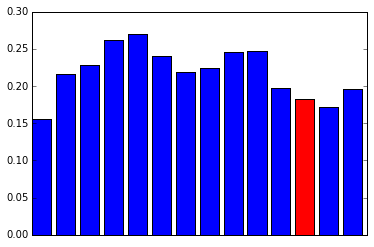

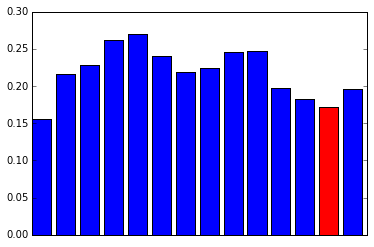

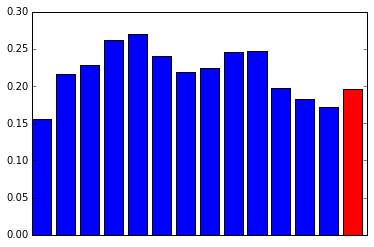

In [18]:
plot_dates = date_list(date(2014,6,1), date.today())
trapRateMeans = []
for endDate in plot_dates:
    df = slicer(endDate, 90)
    myplot = plotmap(df)
    myplot.figure.savefig(endDate.strftime('%Y-%m-%d') + '.png')
    trapRateMeans.append(np.mean(df.trapRate))
plot_bars()

In [19]:
tex = r'''
\documentclass{beamer}
\usepackage[export]{adjustbox}% http://ctan.org/pkg/adjustbox
\setbeamersize{text margin left=1cm,text margin right=1cm}

%\titlehead{Guam Coconut Rhinoceros Project Technical Report\\DRAFT: Work in progress}
\title{Visualization of Pan Trap Data at the University of Guam Yigo Agricultural Experiment Station}
\author{Aubrey Moore}

\begin{document}
\frame{\titlepage}

\begin{frame}{Notes}
\begin{itemize}
    \item Best viewed in with a PDF reader in presentation mode.
    \item This document was generated by an IPython Notebook.
    \item Data required:
    \begin{itemize}
        \item a table containing fields for trap identifier and lat/long coordinates in decimal degrees
        \item a table containing fields for trap identifier, dates for start and end of trapping period, 
and number of beetles trapped duting the trapping period
        \item a polygon (a series of lat/long coordinates in decimal degrees) for the region of interest
    \end{itemize}
\end{itemize}
\end{frame}

'''
for d in plot_dates:
    tex += r'\begin{frame}{Yigo Pan Traps: mean beetles per trap-day for 90 day period ending \textbf{%s}}' % d.strftime('%d %b %y') + '\n'
    tex += r'\includegraphics[width=0.6\linewidth,valign=c]{%s.png}' % d.strftime('%Y-%m-%d') + '\n'
    tex += r'\includegraphics[width=0.4\linewidth,valign=c]{bars%s.png}' % d.strftime('%Y-%m-%d') + '\n'
    tex += r'\end{frame}' + '\n'
tex += r'\end{document}' 

print(tex)
f = open("template.tex", "w")
f.write(tex)
f.close()


\documentclass{beamer}
\usepackage[export]{adjustbox}% http://ctan.org/pkg/adjustbox
\setbeamersize{text margin left=1cm,text margin right=1cm}

%\titlehead{Guam Coconut Rhinoceros Project Technical Report\\DRAFT: Work in progress}
\title{Visualization of Pan Trap Data at the University of Guam Yigo Agricultural Experiment Station}
\author{Aubrey Moore}

\begin{document}
\frame{\titlepage}

\begin{frame}{Notes}
\begin{itemize}
    \item Best viewed in with a PDF reader in presentation mode.
    \item This document was generated by an IPython Notebook.
    \item Data required:
    \begin{itemize}
        \item a table containing fields for trap identifier and lat/long coordinates in decimal degrees
        \item a table containing fields for trap identifier, dates for start and end of trapping period, 
and number of beetles trapped duting the trapping period
        \item a polygon (a series of lat/long coordinates in decimal degrees) for the region of interest
    \end{itemize}
\end{i

In [20]:
%%bash

#use pandoc to convert section one to tex code from markdown
# pandoc -f markdown -t latex section1.txt -o section1.tex 

#run the standard bibtex and pdflatex commands to generate your final pdf

# bibtex test2
pdflatex template.tex 
mv template.pdf trapviz.pdf
xdg-open trapviz.pdf

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(./template.tex
LaTeX2e <2011/06/27>
Babel <3.9k> and hyphenation patterns for 78 languages loaded.
(/usr/local/texlive/2013/texmf-dist/tex/latex/beamer/beamer.cls
(/usr/local/texlive/2013/texmf-dist/tex/latex/beamer/beamerbasercs.sty)
Document Class: beamer 2013/12/02 3.33 A class for typesetting presentations (r
cs-revision 332bfd3ce558)
(/usr/local/texlive/2013/texmf-dist/tex/latex/beamer/beamerbasemodes.sty
(/usr/local/texlive/2013/texmf-dist/tex/latex/beamer/beamerbasedecode.sty))
(/usr/local/texlive/2013/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2013/texmf-dist/tex/latex/beamer/beamerbaseoptions.sty
(/usr/local/texlive/2013/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2013/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2013/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2013/texmf-dist/tex/generi

# Make a movie

In [23]:
%%bash

# Uncomment below to make an mpg movie file

#gs -q -dBATCH -dNOPAUSE -sDEVICE=png16m -r300 -sOutputFile="tm%d.png" "trapviz.pdf"
#avconv -y -r 1 -f image2 -i tm%d.png -r 25 -c:v mpeg2video trapviz.mpg

avconv version 9.18-6:9.18-0ubuntu0.14.04.1, Copyright (c) 2000-2014 the Libav developers
  built on Mar 16 2015 13:19:10 with gcc 4.8 (Ubuntu 4.8.2-19ubuntu1)
[image2 @ 0x22fe160] max_analyze_duration reached
Input #0, image2, from 'tm%d.png':
  Duration: 00:00:16.00, start: 0.000000, bitrate: N/A
    Stream #0.0: Video: png, rgb24, 1512x1134, 1 fps, 1 tbr, 1 tbn
[mpeg @ 0x2300c80] VBV buffer size not set, muxing may fail
Output #0, mpeg, to 'trapviz.mpg':
  Metadata:
    encoder         : Lavf54.20.4
    Stream #0.0: Video: mpeg2video, yuv420p, 1512x1134, q=2-31, 200 kb/s, 90k tbn, 25 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png -> mpeg2video)
Press ctrl-c to stop encoding
frame=  376 fps=125 q=31.0 Lsize=    2512kB time=15.00 bitrate=1371.9kbits/s    
video:2493kB audio:0kB global headers:0kB muxing overhead 0.772595%


# Garbage collection

In [24]:
%%bash
rm template.*
rm *.png